In [1]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

from utilities import *
from torch.nn import Module, Sequential, Conv2d, BatchNorm2d, ReLU, MaxPool2d, AvgPool2d, Linear, Dropout, CrossEntropyLoss
from torch.optim import SGD, Adam
from tqdm import tqdm

In [2]:
# Set seeds for reproducibility
# fix this
seed = 203
torch.manual_seed(seed)

In [3]:
dir_init = './doppler_traces/' #Directory of data
subdirs_init = 'S1a' #Subdirs for training

In [4]:
dataset_csi_train = create_training_set(dir_init=dir_init, subdirs_init=subdirs_init)
dataset_csi_val = create_validation_set(dir_init=dir_init, subdirs_init=subdirs_init)
dataset_csi_test = create_test_set(dir_init=dir_init, subdirs_init=subdirs_init)

#### Model training

In [5]:
from ResNet18 import ResNet18

model = ResNet18()
opt = Adam(model.parameters(), lr=0.0001)
loss_fn = CrossEntropyLoss() # by default reduction="mean" i.e. the output is a scalar
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

epochs=15
best_val = np.inf
train_error = []
validation_error = []
for epoch in range(epochs):
    train_loss = []
    model.train()
    print(f"Epoch: {epoch+1}")
    iterator = tqdm(dataset_csi_train) # iterate over the batches
    for batch_x, batch_y in iterator:
        batch_x = batch_x.to(device) # batch with the inputs
        batch_y = batch_y.to(device) # batch with the labels
        batch_y = t.squeeze(batch_y, dim=1)

        y_pred = model(batch_x) 

        loss = loss_fn(y_pred, batch_y)
 
        opt.zero_grad() 
        loss.backward() #how is it bound to the model?
        opt.step()
        train_loss.append(loss.detach().cpu().numpy())
        iterator.set_description(f"Train loss: {loss.detach().cpu().numpy()}")
    train_error.append(np.mean(train_loss))

    # validation
    model.eval() # what does this change?
    with torch.no_grad():
        predictions = []
        true = []
        for batch_x, batch_y in tqdm(dataset_csi_val):
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            batch_y = t.squeeze(batch_y, dim=1)

            y_pred = model(batch_x)

            predictions.append(y_pred)
            true.append(batch_y)
        predictions = torch.cat(predictions, axis=0) # concatenate the predictions for all batches
        true = torch.cat(true, axis=0)
        val_loss = loss_fn(predictions, true)
        validation_error.append(val_loss.detach().cpu().numpy())

        val_acc = (torch.softmax(predictions, dim=1).argmax(dim=1) == true).float().mean()
        #if true in argsort[:N] per top-N score?
        print(f"loss: {val_loss}, accuracy: {val_acc}")

    if val_loss < best_val:
        print("Saved Model")
        torch.save(model.state_dict(), "model.pt")
        best_val = val_loss

Epoch: 1


100%|██████████| 70/70 [00:32<00:00,  2.16it/s]


loss: 1.6155271530151367, accuracy: 0.4561717212200165
Saved Model
Epoch: 2


100%|██████████| 70/70 [00:42<00:00,  1.65it/s]


loss: 1.2486743927001953, accuracy: 0.5313059091567993
Saved Model
Epoch: 3


100%|██████████| 70/70 [00:37<00:00,  1.88it/s]


loss: 1.4592725038528442, accuracy: 0.49329158663749695
Epoch: 4


100%|██████████| 70/70 [00:37<00:00,  1.88it/s]


loss: 4.898888111114502, accuracy: 0.39624330401420593
Epoch: 5


100%|██████████| 70/70 [00:38<00:00,  1.81it/s]


loss: 1.883500337600708, accuracy: 0.550089418888092
Epoch: 6


100%|██████████| 70/70 [00:36<00:00,  1.90it/s]


loss: 5.632754802703857, accuracy: 0.46466904878616333
Epoch: 7


100%|██████████| 70/70 [00:25<00:00,  2.70it/s]


loss: 1.0115019083023071, accuracy: 0.6355098485946655
Saved Model
Epoch: 8


100%|██████████| 70/70 [00:33<00:00,  2.07it/s]


loss: 1.250617504119873, accuracy: 0.6010733246803284
Epoch: 9


100%|██████████| 70/70 [00:33<00:00,  2.06it/s]


loss: 4.426742076873779, accuracy: 0.5008944272994995
Epoch: 10


100%|██████████| 70/70 [00:25<00:00,  2.71it/s]


loss: 1.8155839443206787, accuracy: 0.5934704542160034
Epoch: 11


100%|██████████| 70/70 [00:26<00:00,  2.69it/s]


loss: 2.190659761428833, accuracy: 0.5442754626274109
Epoch: 12


100%|██████████| 70/70 [00:25<00:00,  2.76it/s]


loss: 9.071340560913086, accuracy: 0.41413238644599915
Epoch: 13


100%|██████████| 70/70 [00:26<00:00,  2.66it/s]


loss: 10.754669189453125, accuracy: 0.4378354251384735
Epoch: 14


100%|██████████| 70/70 [00:35<00:00,  1.96it/s]


loss: 2.426352024078369, accuracy: 0.5062611699104309
Epoch: 15


100%|██████████| 70/70 [00:35<00:00,  1.99it/s]

loss: 1.7401878833770752, accuracy: 0.6118068099021912


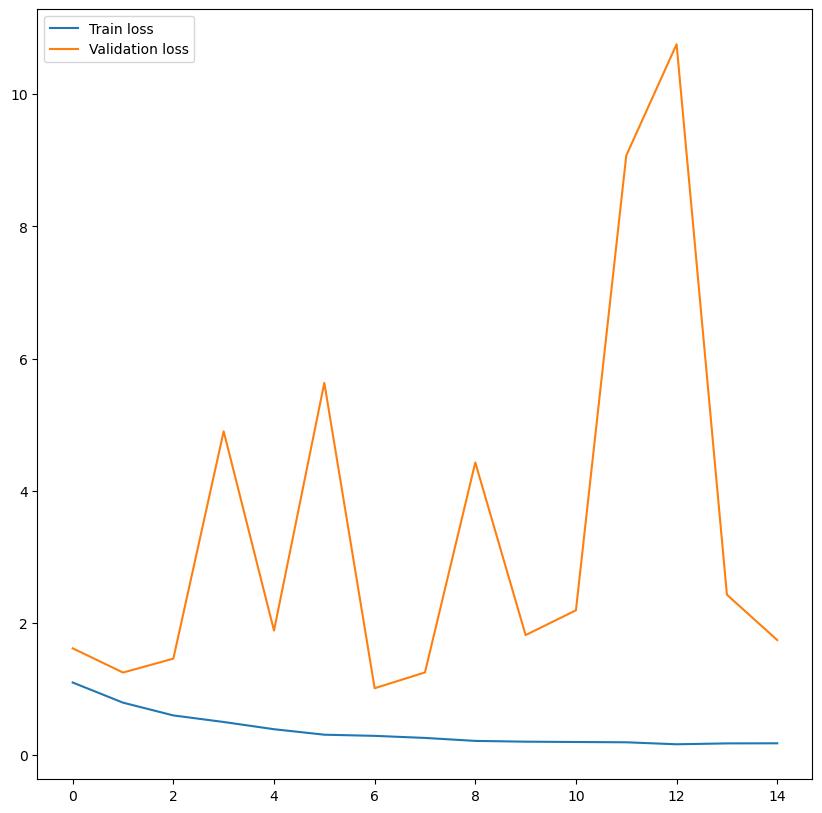

In [6]:
plt.figure(figsize=(10,10))
plt.plot(train_error, label="Train loss")
plt.plot(validation_error, label="Validation loss")
plt.legend()
plt.show()

#### Ratatuja